In [1]:
import pandas as pd
from pycaret.datasets import get_data

#importando paquetes que se van a usar

In [2]:
df_train = pd.read_csv("properties_colombia_train.csv",index_col=False)
df_test = pd.read_csv("properties_colombia_test.csv",index_col=False)

#lectura datos de entrenamiento y prueba

In [3]:
mean_price = int(df_train.price.mean())
df_train['avg'] = df_train['price'].apply(lambda x: 1 if x > mean_price else 0)

# categorización de las propiedades entre baratas o caras, considerando como criterio el valor promedio de los precios
# (la media). 

print(df_train.shape,df_test.shape)

# shape de entrenamiento y testeo

(197549, 28) (65850, 26)


In [ ]:
print(df_train.head(),df_test)

In [ ]:
info = pd.DataFrame(df_train.dtypes, columns=['Dtype'])
info['Unique'] = df_train.nunique().values
info['Null'] = df_train.isnull().sum().values
info

# Análisis del archivo de Entrenamiento para el Data Cleaning

Data Cleaning

In [4]:
df_train.drop(columns = ['id','l4','l5','l6','price_period','start_date','end_date','created_on'], inplace = True)
df_test.drop(columns = ['id','l4','l5','l6','price_period','start_date','end_date','created_on'], inplace = True)

# Estas columnas se borran ya que no tienen incidencia en el target

In [16]:
# Columns with missing values in more than half number of rows
null_cols = [col for col in df_train.columns if df_train[col].isnull().sum() > len(df_train)/2]
null_cols

['rooms', 'bedrooms', 'surface_total', 'surface_covered']

In [ ]:

df_train[df_train.columns[df_train.isnull().any()]].isnull().sum()
df_test[df_test.columns[df_test.isnull().any()]].isnull().sum()

In [5]:
def media_numericos(col):
    if col.dtype == int or col.dtype == float:
        return col.fillna(round(col.mean()), inplace=True)
    else:
        return col.fillna(col.mode()[0], inplace=True)

def media_string_na(col):
        return col.fillna('NA', inplace=True)

# funciones para llenar nulos numéricos y categoricas con su media

In [ ]:
[media_numericos(df_train[col]) for col in ['lat', 'lon','rooms', 'bedrooms','bathrooms','surface_total',
                                                'surface_covered','price']];
[media_string_na(df_train[col]) for col in ['l3','currency','title', 'description']];
df_train[df_train.columns[df_train.isnull().any()]].isnull().sum()

In [ ]:
[media_numericos(df_test[col]) for col in ['lat', 'lon','rooms', 'bedrooms','bathrooms','surface_total',
                                                'surface_covered']];
[media_string_na(df_test[col]) for col in ['l3','currency','title', 'description']];
df_test[df_test.columns[df_test.isnull().any()]].isnull().sum()

# Se rellenan los nulos numericos con la media y categoricas con "NA"

In [ ]:
df_train.describe(exclude='number').transpose()

In [ ]:
df_train["ad_type"] = df_train["ad_type"].astype("category")
df_train["l1"] = df_train["l1"].astype("category")
df_train["l2"] = df_train["l2"].astype("category")
df_train["l3"] = df_train["l3"].astype("category")
df_train["property_type"] = df_train["property_type"].astype("category")
df_train["operation_type"] = df_train["operation_type"].astype("category")
df_train["geometry"] = df_train["geometry"].astype("category")

df_train.info()


In [ ]:
df_test["ad_type"] = df_test["ad_type"].astype("category")
df_test["l1"] = df_test["l1"].astype("category")
df_test["l2"] = df_test["l2"].astype("category")
df_test["l3"] = df_test["l3"].astype("category")
df_test["property_type"] = df_test["property_type"].astype("category")
df_test["operation_type"] = df_test["operation_type"].astype("category")
df_test["geometry"] = df_test["geometry"].astype("category")

df_test.info()

# Conversión de variables tipo object en categoricas

In [18]:
print(df_train.shape,df_test.shape)

(197549, 20) (65850, 18)


In [28]:
import plotly.offline as py
import plotly.graph_objs as go

Cara = df_train[(df_train['avg'] != 0)]
Barata = df_train[(df_train['avg'] == 0)]

def target_count():
    trace = go.Bar( x = df_train['avg'].value_counts().values.tolist(), 
                    y = ['Barata','Cara' ], 
                    orientation = 'h', 
                    text=df_train['avg'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['lightskyblue', 'gold'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Cara - Barata')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

    # Funcion para graficar el balance del target 

In [29]:
target_count()

El conjunto de datos está claramente desbalanceado.No lo tomaremos en cuenta por ahora.

ValueError: num must be 1 <= num <= 9, not 10

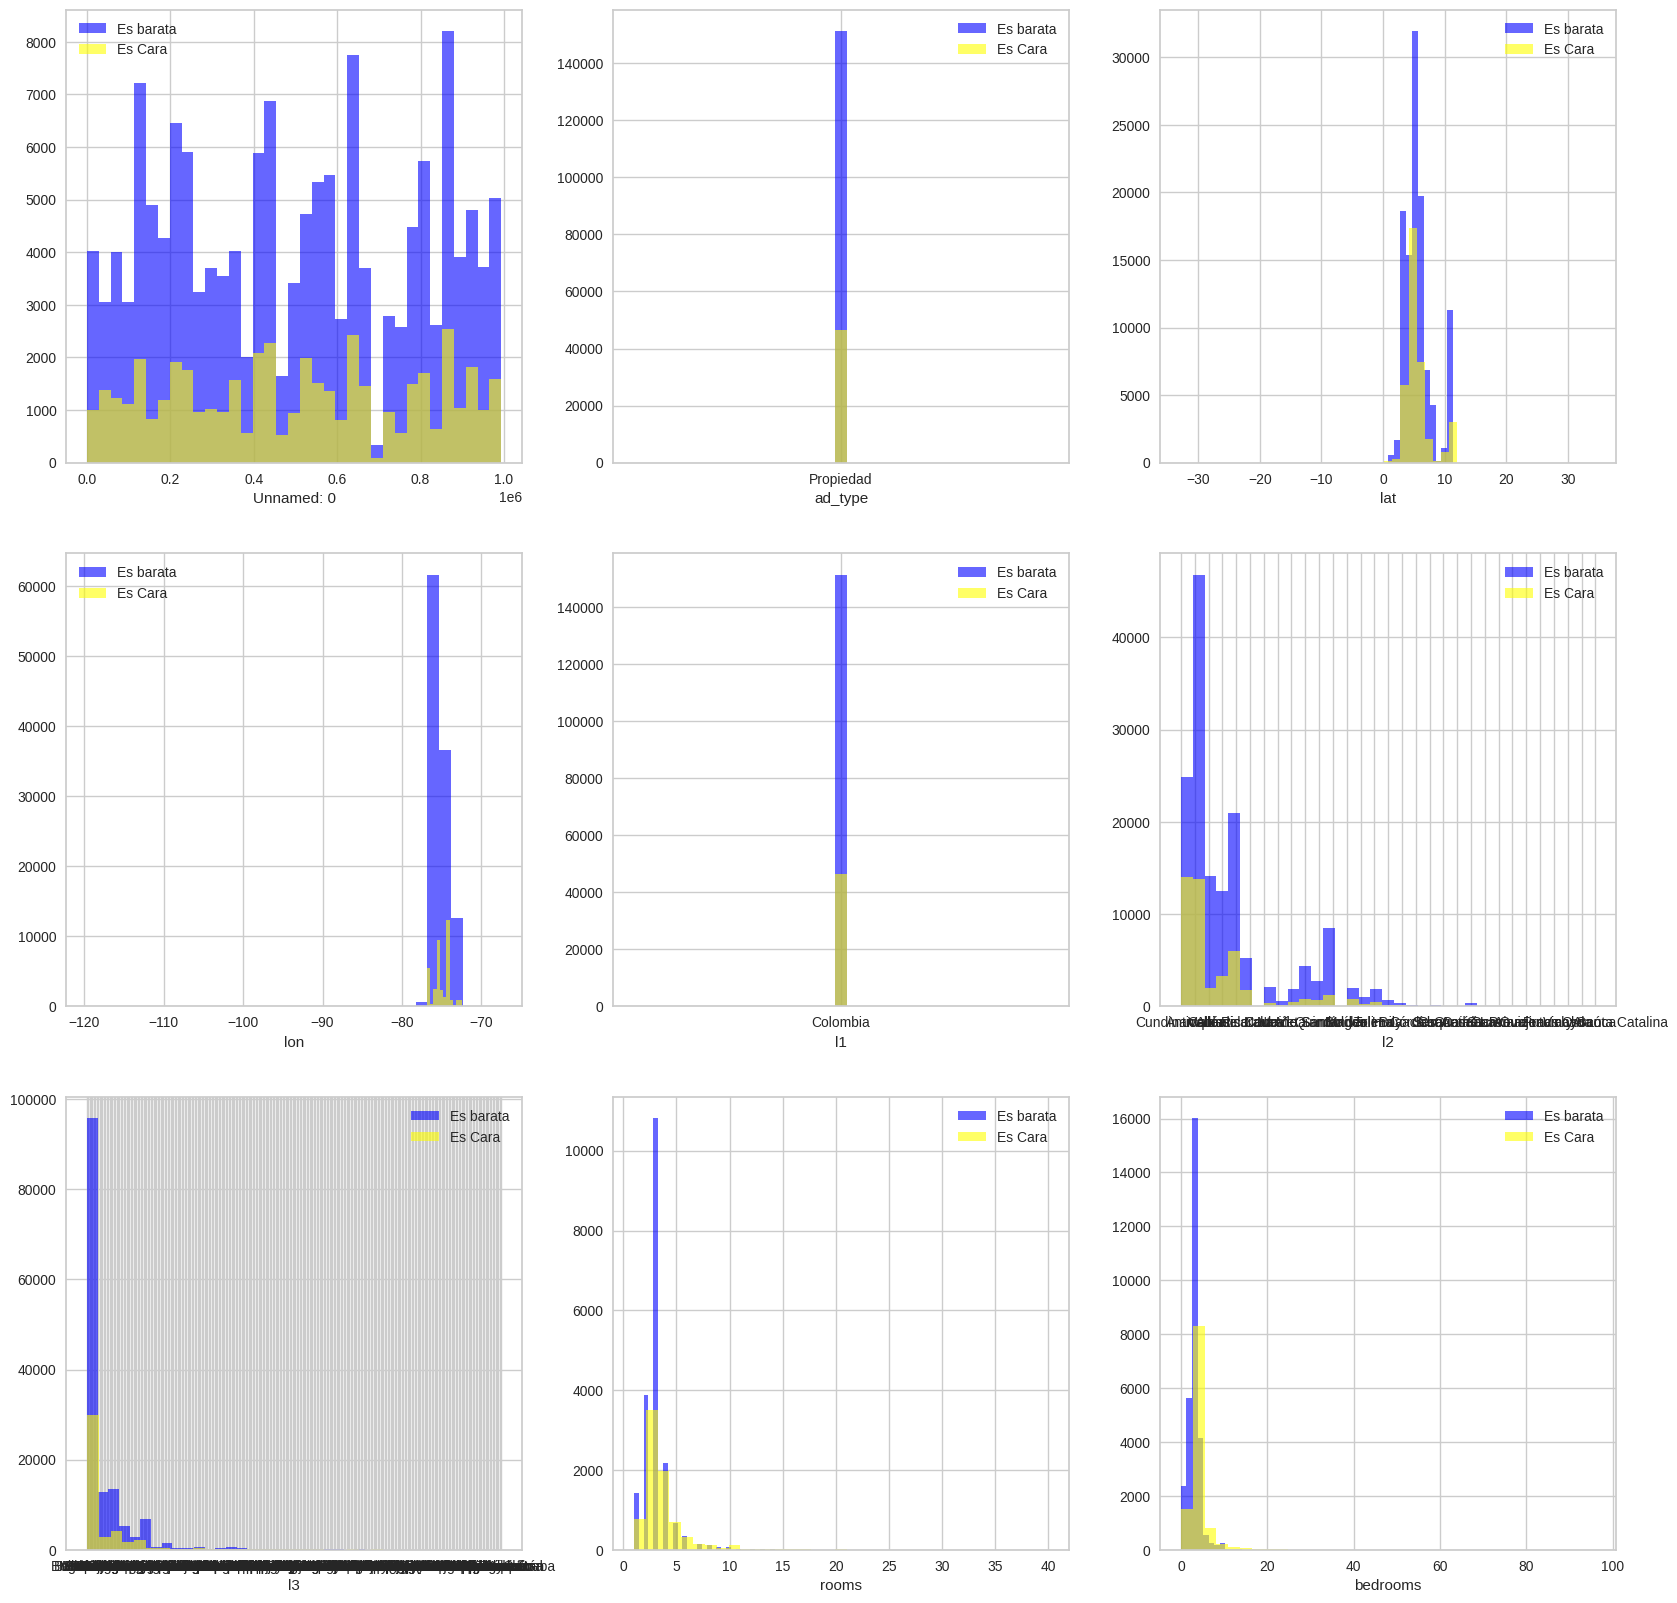

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))

for i, column in enumerate(df_train.columns, 1):
    plt.subplot(3, 3, i)
    df_train[df_train["avg"] == 0][column].hist(bins=35, color='blue', label='Es barata', alpha=0.6)
    df_train[df_train["avg"] == 1][column].hist(bins=35, color='yellow', label='Es Cara', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

# Visualización de la distribución de los datos para cada feature

In [37]:
df_train_ent = df_train.sample(frac=0.80, random_state=786)
df_train_test = df_train.drop(df_train_ent.index).reset_index(drop=True)
df_train_ent.reset_index(drop=True, inplace=True)

print('Datos para Modelar: ' + str(df_train_ent.shape))
print('Datos de testeo para predicciones ' + str(df_train_test.shape))

#Generación del conjunto de datos de entrenamiento y de testeo.



Datos para Modelar: (158039, 20)
Datos de testeo para predicciones (39510, 20)


In [8]:
from pycaret.classification import *

In [9]:
clf = setup(data = df_train_ent, target = 'avg',session_id=1229,normalize=True,transformation=True,
           remove_multicollinearity=True, multicollinearity_threshold=0.95)

# seteo de PyCaret

,Description,Value
0,Session id,1229
1,Target,avg
2,Target type,Binary
3,Original data shape,"(187672, 20)"
4,Transformed data shape,"(187672, 17)"
5,Transformed train set shape,"(131370, 17)"
6,Transformed test set shape,"(56302, 17)"
7,Ordinal features,1
8,Numeric features,9
9,Categorical features,10


In [10]:
compare_models(sort='AUC')

# Comparación de distintos modelos por AUC

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9987,1.0000,0.9991,0.9954,0.9972,0.9964,0.9964,34.3200
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,11.8180
rf,Random Forest Classifier,0.9999,1.0000,0.9997,1.0000,0.9999,0.9998,0.9998,16.0790
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,14.2050
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,18.5640
lda,Linear Discriminant Analysis,0.9768,0.9971,0.9309,0.9691,0.9496,0.9345,0.9348,11.6000
et,Extra Trees Classifier,0.9356,0.9945,0.7278,0.9972,0.8412,0.8021,0.8179,16.9840
knn,K Neighbors Classifier,0.9701,0.9908,0.9212,0.9498,0.9353,0.9159,0.9160,24.9690
qda,Quadratic Discriminant Analysis,0.2352,0.9662,1.0000,0.2349,0.3805,0.0002,0.0106,11.9460
nb,Naive Bayes,0.5474,0.9623,0.9999,0.3416,0.5092,0.2449,0.3735,11.7460


[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1229, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
lr = create_model('lr', fold =10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9985,1.0000,0.9994,0.9942,0.9968,0.9958,0.9958
1,0.9988,1.0000,0.9977,0.9971,0.9974,0.9966,0.9966
2,0.9989,1.0000,0.9984,0.9971,0.9977,0.9970,0.9970
3,0.9992,1.0000,1.0000,0.9968,0.9984,0.9979,0.9979
4,0.9990,1.0000,0.9990,0.9968,0.9979,0.9972,0.9972
5,0.9986,1.0000,0.9990,0.9952,0.9971,0.9962,0.9962
6,0.9985,1.0000,0.9997,0.9939,0.9968,0.9958,0.9958
7,0.9985,1.0000,0.9994,0.9942,0.9968,0.9958,0.9958
8,0.9984,1.0000,0.9981,0.9952,0.9966,0.9956,0.9956


In [ ]:
plot_model(lr)

In [48]:
predict_model(lr)

# predicciones

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9983,1.0000,0.9990,0.9936,0.9963,0.9952,0.9952


,Unnamed: 0,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,geometry,avg,prediction_label,prediction_score
131370,0.152028,0.487750,-0.568390,0.033997,-0.069452,0.071006,0.065907,0.521603,0.116905,0.186602,0.157831,0.010681,-1.114152,0.488684,-0.943558,1.725348,0,0,1.0000
131371,0.436827,0.176285,-0.003373,0.033997,-0.069452,0.071006,0.065907,-0.432759,0.116905,0.186602,0.157831,0.010681,-0.051471,-1.107541,-0.943558,0.250579,0,0,1.0000
131372,0.835826,0.176285,-0.003373,0.033997,-0.069452,0.071006,0.065907,-0.432759,0.116905,0.186602,-0.910719,0.010681,0.115119,-1.107541,-0.943558,0.250579,0,0,1.0000
131373,0.845397,-0.320777,1.012489,1.577600,1.901673,-0.504561,-0.279021,0.223885,0.116905,0.186602,0.509224,0.010681,0.516265,0.488684,0.688658,0.431185,0,0,0.9613
131374,0.151334,0.176285,-0.003373,0.033997,-0.069452,0.071006,0.065907,0.521603,0.116905,0.186602,0.233191,0.010681,-0.677572,-1.107541,-0.943558,0.250579,0,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187667,-0.118803,2.198372,0.160318,-0.331094,-0.218871,0.071006,0.065907,0.223885,0.116905,0.186602,1.526589,0.010681,1.849190,1.855473,1.262379,1.964016,1,1,1.0000
187668,0.101711,0.176285,-0.003373,0.033997,-0.069452,0.071006,0.065907,-0.432759,0.116905,0.186602,-0.041974,0.010681,0.728687,-1.107541,0.688658,0.250579,0,0,1.0000
187669,-1.603379,-0.350029,-0.674583,0.449151,0.544840,0.071006,0.065907,0.223885,0.116905,0.186602,-0.369782,0.010681,0.516265,0.488684,0.688658,0.431185,0,0,1.0000
187670,1.353376,0.176285,-0.003373,-0.331094,-0.218871,0.071006,0.065907,0.521603,0.116905,0.186602,0.188618,0.010681,0.516265,-1.107541,0.688658,0.250579,0,0,1.0000


In [50]:
modelo_final = finalize_model(lr)

# Modelo final

In [51]:
testeo_pre = predict_model(modelo_final, data=df_train_test)
testeo_pre

# Testeo de df_train

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9983,0.9995,0.9971,0.9956,0.9963,0.9952,0.9952


,Unnamed: 0,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,geometry,avg,prediction_label,prediction_score
0,0.249184,0.041166,-0.000175,-1.731568,-1.467327,0.071423,0.063945,-1.968968,0.117301,0.185293,1.384440,0.009722,1.770451,1.771211,1.639800,0.278714,1,1,1.0
1,-0.109460,2.637109,0.242282,-0.289778,-0.189044,0.071423,0.063945,-0.429423,0.117301,0.185293,-0.410550,0.009722,-1.007937,-0.996122,-0.943979,-1.207813,0,0,1.0
2,0.411146,-0.272453,-0.512855,-1.684870,-1.373393,0.071423,0.063945,-0.429423,0.117301,0.185293,-0.660902,0.009722,-1.007937,-0.996122,-0.943979,-1.207813,0,0,1.0
3,-1.604631,-1.213819,-1.409514,-0.090614,0.026680,0.071423,0.063945,-0.429423,0.117301,0.185293,-1.241866,0.009722,0.584105,0.559555,0.686999,-1.207813,0,0,1.0
4,0.646452,0.753406,2.042903,-1.731568,-0.010820,1.339483,1.050530,0.223354,0.117301,0.185293,1.924017,0.009722,0.584105,0.559555,0.686879,0.460479,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39505,-1.215383,-0.337411,-0.588546,-1.684870,0.176238,0.071423,0.063945,0.523832,0.117301,0.185293,-1.106934,0.009722,-1.007937,0.559555,-0.943979,0.460479,0,0,1.0
39506,-0.483110,2.413866,-0.435783,0.890525,0.855219,0.071423,0.063945,-0.429423,0.117301,0.185293,-0.135989,0.009722,-1.007937,-0.996122,-0.943979,0.213662,0,0,1.0
39507,-0.946344,0.041166,-0.000175,-1.729478,-1.464196,0.071423,0.063945,-0.429423,0.117301,0.185293,-0.748859,0.009722,-1.007937,-0.996122,-0.943979,0.278824,0,0,1.0
39508,-0.060656,-0.521485,0.918696,1.576707,1.310963,-0.523657,-0.278573,0.223354,0.117301,0.185293,-1.158946,0.009722,-1.007937,0.559555,-0.943979,-1.207813,0,0,1.0


In [52]:
df_test = df_train.drop(df_train_ent.index).reset_index(drop=True)

In [53]:
testeo_pre = predict_model(modelo_final, data=df_test)
testeo_pre

# Testeo con df_test ( properties_colombia_test.csv )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9988,0.9999,0.9979,0.9968,0.9974,0.9966,0.9966


,Unnamed: 0,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,geometry,avg,prediction_label,prediction_score
0,0.232090,-0.657756,-0.135758,-0.600087,-0.804493,0.071423,0.063945,-0.429423,0.117301,0.185293,-0.913333,0.009722,0.584105,0.559555,-0.943979,0.460479,0,0,1.0000
1,-1.101791,0.770525,1.227088,-1.729478,-1.656374,0.071423,0.063945,-0.429423,0.117301,0.185293,-0.503856,0.009722,-1.007937,-0.996122,1.639963,-1.207813,0,0,1.0000
2,0.437795,0.041166,-0.000175,0.014421,1.562085,0.071423,0.063945,0.523832,0.117301,0.185293,0.638376,0.009722,1.770451,1.771211,0.686879,0.278714,1,1,0.9798
3,-2.244872,-0.288095,-0.454630,-1.684870,-1.373393,0.071423,0.063945,-0.429423,0.117301,0.185293,-0.135989,0.009722,0.584105,0.559555,0.686999,0.460479,0,0,1.0000
4,0.517773,0.294575,-0.606635,0.014664,-1.607740,-2.994379,-1.878713,0.223354,0.117301,0.185293,-0.245174,0.009722,-1.007937,0.559555,-0.943979,0.460479,0,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39505,-0.060656,-0.521485,0.918696,1.576707,1.310963,-0.523657,-0.278573,0.223354,0.117301,0.185293,-1.158946,0.009722,-1.007937,0.559555,-0.943979,-1.207813,0,0,1.0000
39506,1.476920,-0.511084,1.030515,1.576707,1.310963,0.071423,0.063945,-1.968968,0.117301,-5.990751,-1.106934,0.009722,0.584105,-0.996122,1.242306,-1.207813,0,0,1.0000
39507,0.148012,-1.250605,-1.567541,-0.090614,0.026680,0.071423,0.063945,-1.968968,0.117301,0.185293,0.396729,0.009722,-1.007937,-0.996122,1.639963,1.050432,0,0,1.0000
39508,0.268881,-0.507183,0.934243,1.576707,1.310963,0.071423,0.063945,-0.429423,0.117301,0.185293,-0.245174,0.009722,-1.007937,-0.996122,0.686999,-1.207813,0,0,1.0000


In [54]:
entrega = pd.DataFrame({
        "pre": testeo_pre['prediction_label']
    })

entrega.to_csv('GyGuillermo.csv', index=False)

# Generación csv de entrega